# KhartoumKernel Team Soltuion - 6th place
# Competition Link: https://zindi.africa/competitions/digital-green-crop-yield-estimate-challenge

### Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBRegressor, XGBClassifier

from sklearn.feature_extraction.text import CountVectorizer

### Read Data

In [6]:
# Load files
data_path = '/kaggle/input/digital-green-crop-yield-estimate-challenge/digital-green-crop-yield-estimate-challenge20230912-4562-1bbmstk/'
train_df = pd.read_csv(data_path + 'Train.csv')
test_df = pd.read_csv(data_path + 'Test.csv')
sample_submission = pd.read_csv(data_path + 'SampleSubmission.csv')
variable_desc = pd.read_csv(data_path + 'VariableDescription.csv')

In [7]:
ID = test_df['ID']
train_df.drop('ID',inplace=True,axis=1)
test_df.drop('ID',inplace=True,axis=1)

### Date Features

In [8]:
import numpy as np

# List of date features
date_feats = ['CropTillageDate', 'RcNursEstDate', 'SeedingSowingTransplanting', 'Harv_date', 'Threshing_date']

# Convert the date columns to datetime in both train and test datasets
for df in [train_df, test_df]:
    for feat in date_feats:
        df[feat] = pd.to_datetime(df[feat], errors='coerce')

# Extract date components from each feature
for dataset in [train_df, test_df]:
    for feat in date_feats:
        # Extracting different components of the datetime object
        dataset[f'{feat}_Int'] = dataset[feat].astype('datetime64[ns]').astype(np.int64) * 1e-9
        dataset[f'{feat}_Day'] = dataset[feat].dt.day
        dataset[f'{feat}_week'] = dataset[feat].dt.isocalendar().week
        dataset[f'{feat}_Month'] = dataset[feat].dt.month
        dataset[f'{feat}_Day_Month'] = dataset[feat].dt.day.astype(str) + dataset[feat].dt.month.astype(str)
        
        
        # Drop the original date column if not needed
        dataset.drop(feat, inplace=True, axis=1)


In [9]:
def create_fertilizer_interactions(df):
    """
    Create interaction features related to fertilizers.
    """
    # Interaction between BasalDAP and 1tdUrea
    df['BasalDAP_1tdUrea_interaction'] = df['BasalDAP'] * df['1tdUrea']
    
    # Interaction between BasalUrea and 2tdUrea
    df['BasalUrea_2tdUrea_interaction'] = df['BasalUrea'] * df['2tdUrea']
    
    return df

train_df = create_fertilizer_interactions(train_df)
test_df = create_fertilizer_interactions(test_df)

In [10]:
# Create a ratio of 'CultLand' to 'CropCultLand' and 'CropTillageDepth' to 'StandingWater'
train_df['CultLand_to_CropCultLand'] = train_df['CultLand'] / (train_df['CropCultLand'] + 1)  # Added 1 to avoid division by zero
train_df['CropTillageDepth_to_StandingWater'] = train_df['CropTillageDepth'] / (train_df['StandingWater'] + 1)  # Added 1 to avoid division by zero

test_df['CultLand_to_CropCultLand'] = test_df['CultLand'] / (test_df['CropCultLand'] + 1)  # Added 1 to avoid division by zero
test_df['CropTillageDepth_to_StandingWater'] = test_df['CropTillageDepth'] / (test_df['StandingWater'] + 1)  # Added 1 to avoid division by zero

### Count Vectorizer

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

feats = ['NursDetFactor', 'LandPreparationMethod', 'TransDetFactor', 'OrgFertilizers', 'CropbasalFerts', 'FirstTopDressFert']

# Initialize CountVectorizer
CouVec = CountVectorizer(stop_words='english')

# Combine train and test data for fitting the vectorizer
df_combined = pd.concat([train_df, test_df])

# Iterate over each feature
for feature in feats:
    # Fit the vectorizer to the combined data for this feature
    CouVec.fit(df_combined[feature].fillna(''))

    # Transform the data and create a dataframe
    train_words = pd.DataFrame(CouVec.transform(train_df[feature].fillna('')).toarray(), columns=CouVec.get_feature_names_out())
    test_words = pd.DataFrame(CouVec.transform(test_df[feature].fillna('')).toarray(), columns=CouVec.get_feature_names_out())

    # Rename the columns to have the desired format
    train_words = train_words.add_prefix(f'_{feature}_')
    test_words = test_words.add_prefix(f'_{feature}_')

    # Concatenate with the original dataframes
    train_df = pd.concat([train_df, train_words], axis=1)
    test_df = pd.concat([test_df, test_words], axis=1)

### Aggregations

In [12]:
import pandas as pd
import numpy as np

def find_nearest_valid_value(value, valid_values):
    # Find the nearest value from the valid_values list
    array = np.asarray(valid_values)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Combine train and test for processing
fs = ['Acre']
for f in fs:
    combined_df = pd.concat([train_df[f], test_df[f]], ignore_index=True)
    combined_df_modified = combined_df.copy()

    # Keep iterating until condition is met
    while True:
        # Calculate the value counts
        value_counts = combined_df_modified.value_counts()

        # Filter the value counts to find unique values with less than 5 samples
        small_counts = value_counts[value_counts < 3]

        # If there are no small counts left, break the loop
        if small_counts.empty:
            break

        # Get the valid values which have 5 or more samples
        valid_values = value_counts[value_counts >= 3].index.tolist()

        # Replace the values
        for val in small_counts.index:
            nearest_valid_value = find_nearest_valid_value(val, valid_values)
            combined_df_modified.replace(val, nearest_valid_value, inplace=True)

    train_df[f'{f}_modified'] = combined_df_modified[:len(train_df)].values
    test_df[f'{f}_modified'] = combined_df_modified[len(train_df):].values


def Agg(Feature):
    for dataset in (train_df,test_df):
        for feat_1 in ['Acre_modified','Block','District']:
            dataset[f'{Feature}_Agg_{feat_1}_max'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].max()))
            dataset[f'{Feature}_Agg_{feat_1}_mean'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].mean()))
            dataset[f'{Feature}_Agg_{feat_1}median'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].median()))
            dataset[f'{Feature}_Agg_{feat_1}_var'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].var()))
            
Agg('Yield')

### Encoding

In [13]:
feats = list(train_df.select_dtypes(include=['object','category']).columns)
le = LabelEncoder()
df = pd.concat([train_df, test_df])
for f in feats:
    le.fit(df[f])
    train_df[f] = le.transform(train_df[f])
    test_df[f] = le.transform(test_df[f])

## Modeling

In [14]:
feats = train_df.columns.drop(['Yield'])

In [15]:
def pseudo_huber_loss(y_pred, y_val):
    d = (y_val-y_pred)
    delta = 9  
    scale = 1 + (d / delta) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt 
    hess = (1 / scale) / scale_sqrt
    return grad, hess

xg = XGBRegressor(n_estimators=1000,  
                  learning_rate=0.05,  
                  max_depth=5, 
                  random_state=42, 
                  objective=pseudo_huber_loss)

Validating...


100%|██████████| 3/3 [01:27<00:00, 29.14s/it]


OOF RMSE: 470.7052953754608
OOF MedAE: 25.465721130371094


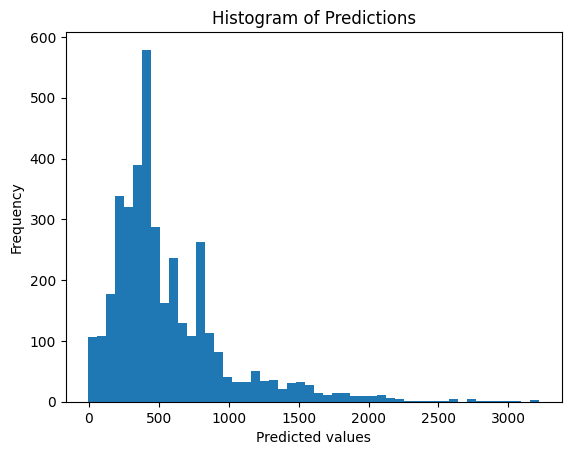

In [16]:
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print('Validating...')

X = train_df.drop('Yield', axis=1)[feats]
y = train_df['Yield']

# Initialize the dataframe to store out-of-fold predictions
oof_train = train_df.reset_index(drop=True).copy()
oof_train['y_pred'] = 0  # Placeholder for predictions

# Generate stratification based on 'District' and binned 'Yield'
Yield_binned = pd.qcut(train_df['Yield'], q=10, labels=False)
strat = train_df['District'].astype(str) + pd.Series(Yield_binned).astype(str)

# Initialize the list to store the fold-wise predictions
oof_predictions = []

# Cross-validation loop
bags = 3
for bag in tqdm(range(bags)):
    for i, (train_index, test_index) in enumerate(StratifiedKFold(n_splits=5, shuffle=True, random_state=bag).split(X, strat)):
        X_Train, X_Test = X.loc[train_index, :], X.loc[test_index, :]
        y_Train, y_Test = y[train_index], y[test_index]

        # Train model here. 
        xg.fit(X_Train, y_Train)
        y_pred = xg.predict(X_Test)

        oof_train.loc[test_index, 'y_pred'] += y_pred / bags

        # Inference on test set
        if (bag == 0) and (i == 0):
            oof_test =  xg.predict(test_df[feats]) / (5*bags)
        else:
            oof_test +=  xg.predict(test_df[feats]) / (5*bags)
     
oof_train.loc[test_index, 'y_pred'] = np.clip(oof_train.loc[test_index, 'y_pred'].values,train_df['Yield'].min(),train_df['Yield'].max())
oof_test = np.clip(oof_test,train_df['Yield'].min(),train_df['Yield'].max())

# Calculate RMSE for the out-of-fold predictions in the original scale
oof_rmse = mean_squared_error(oof_train['Yield'], oof_train['y_pred'], squared=False)
print(f"OOF RMSE: {oof_rmse}")
oof_MedAE = median_absolute_error(oof_train['Yield'], oof_train['y_pred'])
print(f"OOF MedAE: {oof_MedAE}")

# Plot the histogram of the predictions in the original scale
plt.hist(oof_train['y_pred'], bins=50)
plt.xlabel('Predicted values')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')
plt.show()

In [17]:
Predictions = oof_test.copy()

Predictions = pd.DataFrame(Predictions, index = test_df.index)
submission = pd.DataFrame({"ID": ID ,"Yield": Predictions.values.squeeze()})
submission.to_csv('Submission.csv',index=False)

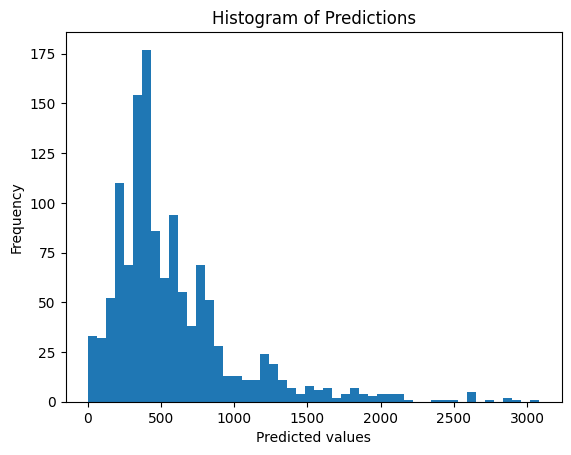

In [18]:
plt.hist(submission['Yield'], bins=50)
plt.xlabel('Predicted values')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')
plt.show()